In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pandas as pd
import numpy as np
from src.icc import calculate_icc_by_metric_and_state, plot_icc_results

In [3]:
older_adults_trial_level = pd.read_csv("../../data/processed/older_adults/filtered_measurements.csv")
older_adults_average_level = pd.read_csv("../../data/processed/older_adults/average_measurements.csv")
students_trial_level = pd.read_csv("../../data/processed/students/measurements.csv")
students_average_level = pd.read_csv("../../data/processed/students/average_measurements.csv")

# Older Adults

### Trial-level

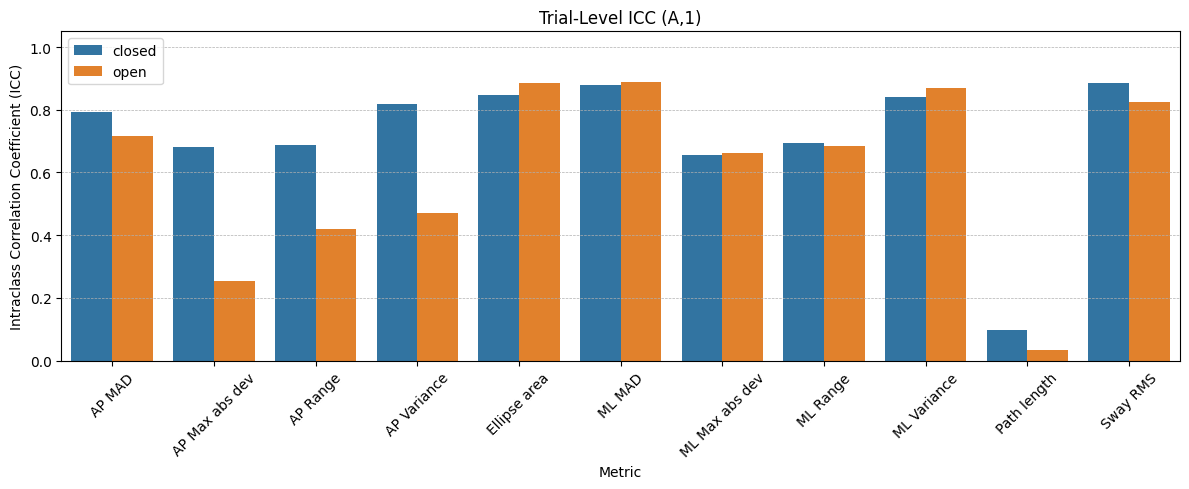

In [4]:
icc_trial_df = calculate_icc_by_metric_and_state(older_adults_trial_level, trial_level=True)
plot_icc_results(icc_trial_df, title='Trial-Level ICC (A,1)')

### Average-level

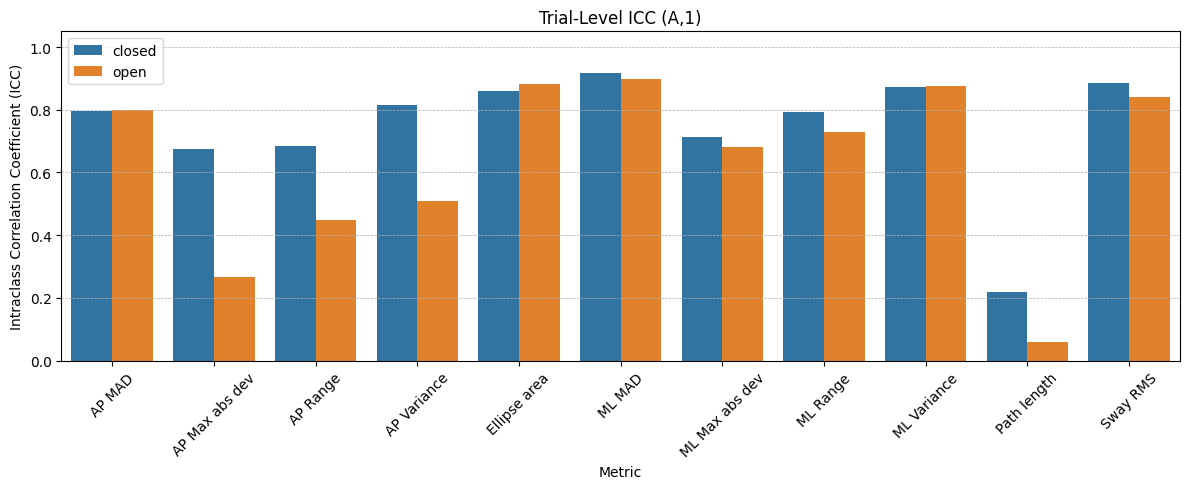

In [5]:
icc_trial_df = calculate_icc_by_metric_and_state(older_adults_average_level, trial_level=False)
plot_icc_results(icc_trial_df, title='Trial-Level ICC (A,1)')

# Students

### Trial-level

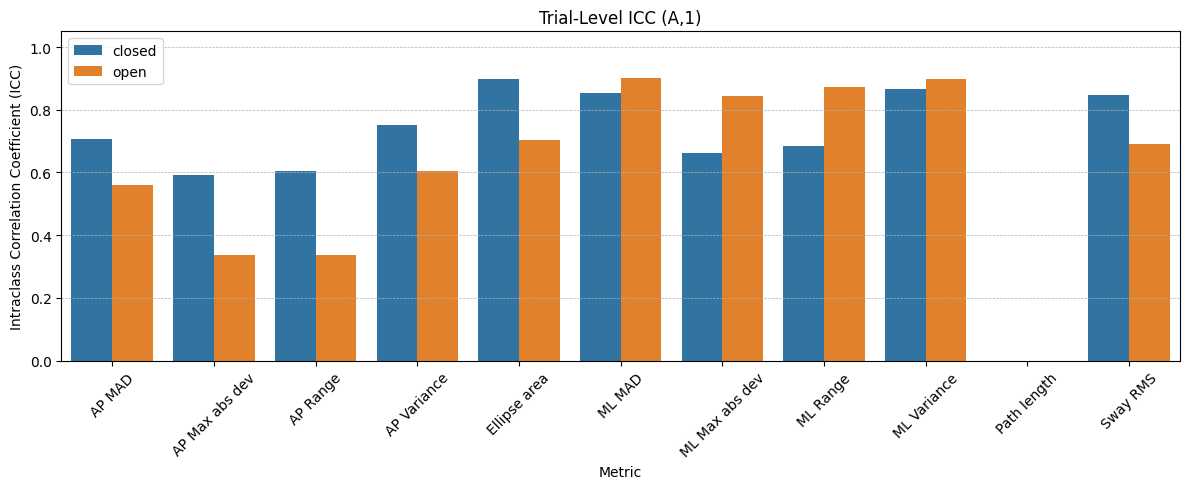

In [6]:
icc_trial_df = calculate_icc_by_metric_and_state(students_trial_level, trial_level=True)
plot_icc_results(icc_trial_df, title='Trial-Level ICC (A,1)')

### Average-level

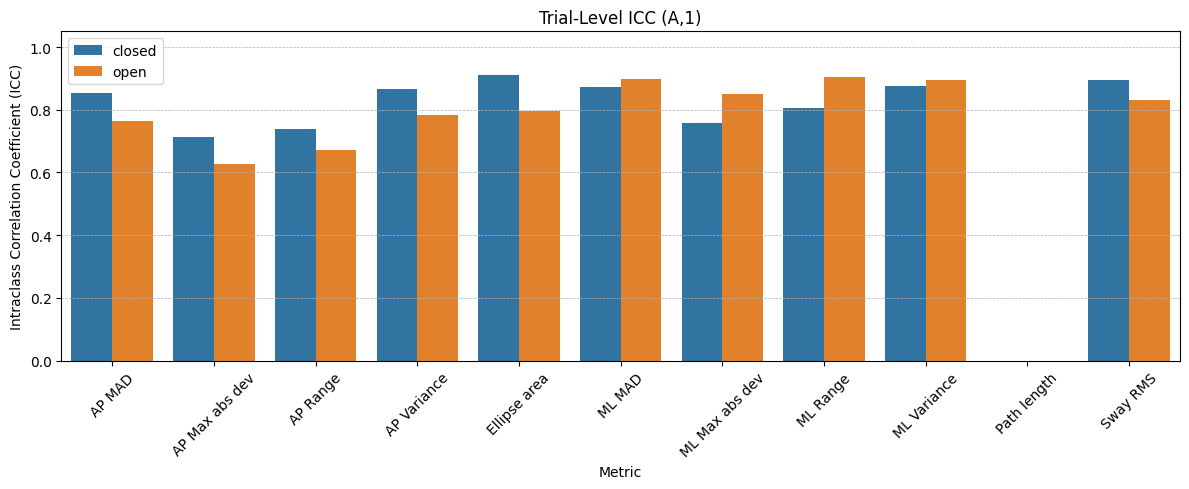

In [7]:
icc_trial_df = calculate_icc_by_metric_and_state(students_average_level, trial_level=False)
plot_icc_results(icc_trial_df, title='Trial-Level ICC (A,1)')